In [3]:
%matplotlib inline
import numpy as np
import pandas as pd 
import os

## Lecture et concaténation de tous les fichiers 

In [4]:
allfiles = os.listdir('./data/data valid/')
li = []

for file in allfiles : 
    file = './data/data valid/' + file 
    if file[-3:] == 'csv':
        li.append(pd.read_csv(file, header=0, sep=';'))
    else:
        li.append(pd.read_csv(file, header=0, sep='\t'))

dt = pd.concat(li, axis=0, ignore_index=True)

## Modification des types 

In [5]:
dt.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,01/07/2015,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,241
1,01/07/2015,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,215
2,01/07/2015,100,110,1,PORTE MAILLOT,71379,FGT,518
3,01/07/2015,100,110,1,PORTE MAILLOT,71379,IMAGINE R,2556
4,01/07/2015,100,110,1,PORTE MAILLOT,71379,NAVIGO,14463


#### 8% des données ont la valeur "moins de 5" 

In [7]:
dt.loc[dt['NB_VALD'] == 'Moins de 5'].shape[0]/dt.shape[0]*100

9.450435321932229

In [8]:
dt.loc[dt['NB_VALD'] == 'Moins de 5'] = 5
dt['NB_VALD'] = pd.to_numeric(dt['NB_VALD'])

In [9]:
dt['JOUR'] = dt['JOUR'].astype(str)

In [10]:
dt.dtypes

JOUR               object
CODE_STIF_TRNS      int64
CODE_STIF_RES      object
CODE_STIF_ARRET    object
LIBELLE_ARRET      object
ID_REFA_LDA        object
CATEGORIE_TITRE    object
NB_VALD             int64
dtype: object

In [11]:
dt_agg = pd.DataFrame(dt.groupby(["JOUR","LIBELLE_ARRET"])['NB_VALD'].sum().reset_index())

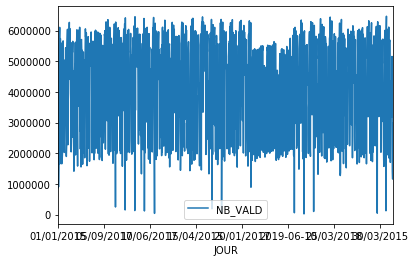

In [12]:
dt_agg.groupby('JOUR').sum().plot()

In [14]:
dt_agg.to_csv('./data/validation_data_agg_2015_2019.csv')

## Merge positions

In [17]:
pos = pd.read_csv("../positions-geographiques-des-stations-du-reseau-ratp.csv", sep=';')
dt2 = pos[['Name','Coordinates']].copy()

l = np.array(dt2["Coordinates"].str.split(",").tolist())
dt2["lon"] = l[:,0]
dt2["lat"] = l[:,1]
dt2.drop("Coordinates",axis=1, inplace=True)
#dt2["lon"] = dt2["lon"].str[0:6]
#dt2["lat"] = dt2["lat"].str[0:6]

#dt2.rename(columns={'Name':'LIBELLE_ARRET'}, inplace=True)
dt2['Name'] = dt2['Name'].str.lower()
dt2['Name'] = dt2['Name'].str.replace('[^\w]','')
dt2['Name'] = dt2['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt2['lon'] = pd.to_numeric(dt2["lon"])
dt2['lat'] = pd.to_numeric(dt2["lat"])

dt2 = dt2.groupby('Name').mean().reset_index()
dt2.drop_duplicates(inplace=True)

dt2.head()

,Name,lon,lat
0,11novembre,48.849993,2.395659
1,11novembre1918,48.824212,2.516243
2,11novembrecourcellesuryvetterer,48.700031,2.099321
3,12fevrier1934,48.817827,2.308055
4,17octobre1961,48.898062,2.216702


In [18]:
dt_agg['Name'] = dt_agg['LIBELLE_ARRET'].str.lower()
dt_agg['Name'] = dt_agg['Name'].str.replace('[^\w]','')
dt_agg['Name'] = dt_agg['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [20]:
dt_agg_pos = dt_agg.merge(dt2, how='left', on='Name')
dt_agg_pos.drop('Name',axis=1,inplace=True)
dt_agg_pos.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat
0,01/01/2015,ABBESSES,750,48.884505,2.338365
1,01/01/2015,ABLON,108,NaN,NaN
2,01/01/2015,ACHERES-GRAND-CORMIER,8,48.955388,2.092457
3,01/01/2015,ACHERES-VILLE,482,48.970248,2.077672
4,01/01/2015,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357
